In [1]:
import numpy as np
import tidy3d as td
import math
from collections import namedtuple
import matplotlib.pyplot as plt
import random
import tidy3d as td
import tidy3d.web as web
import itertools
from shapely.geometry import Point, Polygon, MultiPoint
import pandas as pd
from descartes import PolygonPatch
import alphashape
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pygad
import time
import h5py
import os
import gdstk
import nbimporter
%run fan_generation.ipynb


desired_temperature = 450


In [2]:
#function to prepare the simulation
def make_sim(solution):
    fans =  generate_fan_list(solution)
    fan_structure_0 = fan_structure.generate_fan_from_centre(fans[0])
    fan_structure_1 = fan_structure.generate_fan_from_centre(fans[1])
    fan_structure_2 = fan_structure.generate_fan_from_centre(fans[2])
    fan_structure_3 = fan_structure.generate_fan_from_centre(fans[3])



    scene_planar = td.Scene(
        structures= [planar_vac]  + [planar_bottom_layer] + fan_structure_0 + fan_structure_1 + fan_structure_2+ fan_structure_3  + [planar_top_layer]  + [planar_vac2],
        medium=background_medium,
    )
    # simulation domain parameter
    heat_sim_planar = td.HeatSimulation(
        center=(r1/2, r1/2, 4),
        size=(r1 + 0.1, r1 + 0.1, 24.5),
        medium=scene_planar.medium,
        structures= scene_planar.structures,
        boundary_spec=[bc_side, bc_vac],
        sources=[source_top],
        grid_spec=td.UniformUnstructuredGrid(dl = 0.25),
        #grid_spec=td.DistanceUnstructuredGrid(dl_interface=0.05, distance_interface=0.2, dl_bulk=0.25, distance_bulk=0.5),
        monitors=[temp_mnt, temp_mnt_ugrid],
        symmetry=(0, 0, 0)
    )
    return heat_sim_planar

In [3]:
#function to prepare the simulation
def make_sim_petal(solution):
    fans = generate_petal_fan_list(solution)
    fan_structure_list = []
    fans_on_top = []
    fans_on_top_objects = []
    fan_structure_list.append(fan_structure.generate_petal_fan(fans[0], solution[2], solution[3]))

    fans_on_top.extend(fan_structure.generate_nonlinear_fan_on_top(fans[0], 1, 2, 40, 3)[0])
    fans_on_top_objects.extend(fan_structure.generate_nonlinear_fan_on_top(fans[0], 1, 2, 40, 3)[1])

    i = 4
    for z in range(1, 4):
        fan_structure_list[0] += fan_structure.generate_petal_fan(fans[z], solution[i+2], solution[i+3])
        fans_on_top.extend(fan_structure.generate_nonlinear_fan_on_top(fans[z], 1, 2, 40, 3)[0])
        fans_on_top_objects.extend(fan_structure.generate_nonlinear_fan_on_top(fans[z], 1, 2, 40, 3)[1])
        i += 4
    
    # for i in range(3):
    #     fan_structure_list[0] += fans_on_top[i]


    scene_planar = td.Scene(
        structures= [planar_vac]  + [planar_bottom_layer] + fan_structure_list[0]  + [planar_top_layer]  + [planar_vac2],
        medium=background_medium,
    )
    # simulation domain parameter
    heat_sim_planar = td.HeatSimulation(
        center=(r1/2, r1/2, 4),
        size=(r1 + 0.1, r1 + 0.1, 24.5),
        medium=scene_planar.medium,
        structures= scene_planar.structures,
        boundary_spec=[bc_side, bc_vac],
        sources=[source_top],
        grid_spec=td.UniformUnstructuredGrid(dl = 0.5),
        #grid_spec=td.DistanceUnstructuredGrid(dl_interface=0.05, distance_interface=0.2, dl_bulk=0.25, distance_bulk=0.5),
        monitors=[temp_mnt, temp_mnt_ugrid],
        symmetry=(0, 0, 0)
    )
    return heat_sim_planar

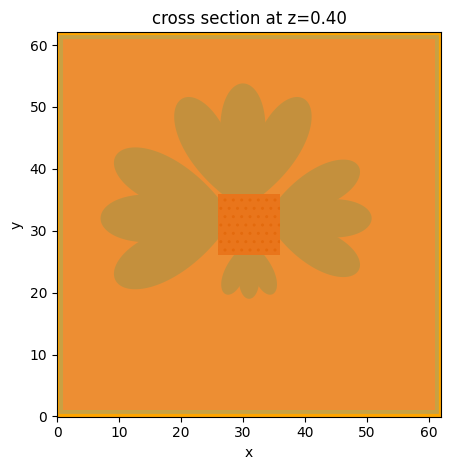

In [4]:
solution = custom_initial_population_petal(1, 4)
sim = make_sim_petal(solution[0])
sim.plot(z=0.4)
plt.show()


In [9]:
alpha = 1


def fitness_function(ga_instance, solution_array, solution_indices):
    center_x, center_y = 31, 31  
    inner_half_width = 5  
    outer_half_width = 10  
    z_plane = 0.4  

    sims = {}
    fitness = []
    solution_array = np.array(solution_array)

    # 1. Create simulations
    for i, sol in enumerate(solution_array):
        sim = make_sim_petal(sol)
        sims[f"sim_{i}"] = sim

    # 2. Submit as batch
    batch = web.Batch(simulations=sims, verbose=False)
    batch_results = batch.run(path_dir="data")
    print("Batch submitted.")

    # 3. Load and process each simulation individually
    for task_name, task_id in batch_results.task_ids.items():
        print(f"Loading task {task_name} (ID: {task_id})...")

        # Load simulation data directly via task_id
        sim_data = web.load(task_id, verbose=False)
        temperature_data = sim_data["temperature"].temperature

       
        x_coords = sim_data["temperature"].temperature.coords["x"]
        y_coords = sim_data["temperature"].temperature.coords["y"]
        z_coords = sim_data["temperature"].temperature.coords["z"]
        z_plane = 0.4
        
        z_idx = np.abs(z_coords - z_plane).argmin()
        temperature_slice = temperature_data.isel(z=z_idx)  # Safely slices along z
        

        x_grid, y_grid = np.meshgrid(x_coords, y_coords, indexing="ij")

        in_outer = (np.abs(x_grid - center_x) <= outer_half_width) & \
                (np.abs(y_grid - center_y) <= outer_half_width)

        out_inner = (np.abs(x_grid - center_x) > inner_half_width) | \
                    (np.abs(y_grid - center_y) > inner_half_width)

        ring_mask = in_outer & out_inner

        temps = temperature_slice.values[ring_mask]
        avg_temp = np.mean(temps)
        var_temp = np.var(temps)

        if avg_temp >= desired_temperature:
            score = (avg_temp - desired_temperature + 1e-6) / (var_temp + 1e-6)
        else:
            score = 1 / (desired_temperature - avg_temp + var_temp + 1e-6)

        fitness.append(score)
        print(f"Task {task_name} fitness: {score}")

    return fitness


In [5]:
def on_gen(ga_instance):
    best_fitness = ga_instance.best_solution(ga_instance.last_generation_fitness)[1]
    generation = ga_instance.generations_completed
    print(f"Generation:{generation}: Best Fitness = {best_fitness:.3f}")
    time.sleep(3)

In [7]:
def custom_uniform_crossover(parents, offspring_size, ga_instance):
    """
    Custom uniform crossover to generate offspring with a customizable gene selection probability.

    Args:
        parents (numpy.ndarray): A 2D array where each row represents a parent solution.
        offspring_size (tuple): A tuple specifying the size of the offspring (rows, columns).
        ga_instance: The GA instance calling this function (not used here directly).

    Returns:
        numpy.ndarray: A 2D array containing the offspring population.
    """
    offspring = np.empty(offspring_size)
    gene_selection_probability = 0.5  # Probability of selecting a gene from Parent 1

    # Iterate through each offspring
    for k in range(offspring_size[0]):  # Loop over number of offspring
        # Select two parents
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        valid_offspring = False
        
        while not valid_offspring:

            # Generate a random binary mask for each gene based on the selection probability
            mask = np.random.rand(offspring_size[1]) < gene_selection_probability
            child = np.where(mask, parents[parent1_idx, :], parents[parent2_idx, :])
            if not check_boundaries_petal(child):
                valid_offspring = True
                offspring[k, :] = child

            

    

    return offspring

In [11]:
num_generations = 10
sol_per_pop = 30
num_parents_mate = 25

#GA instance
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mate,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=4*4,
                       initial_population= custom_initial_population_petal(sol_per_pop, 4),
                       parent_selection_type="tournament",
                       keep_parents=10,
                       crossover_type=custom_uniform_crossover,
                       on_generation=on_gen,
                       mutation_type=None,
                       fitness_batch_size=sol_per_pop,
                       mutation_percent_genes=0,
                       )

ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

c:\Users\A\tidy3d\.conda\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


08:54:39 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

08:54:44 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

08:54:45 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

08:54:46 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

08:54:48 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

08:54:51 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

08:54:57 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

08:57:34 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

08:57:37 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

08:57:38 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

08:57:39 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

08:57:41 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

08:57:42 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

08:57:43 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

09:00:54 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

Batch submitted.
Loading task sim_0 (ID: he-339a9898-05b9-418b-8493-036defd2806e)...
Task sim_0 fitness: 0.08403058431685248
Loading task sim_1 (ID: he-73c3fe78-be0d-4e56-a09a-667e0663f88f)...
Task sim_1 fitness: 0.1411401673942702
Loading task sim_2 (ID: he-e7140f60-488a-44f4-9a3e-4a3ff795a490)...
Task sim_2 fitness: 0.16170447769761642
Loading task sim_3 (ID: he-b3aa7563-b22a-44c9-89e8-4b64c456d44e)...
Task sim_3 fitness: 0.12072215809138309
Loading task sim_4 (ID: he-bdfa6647-8c43-4f81-b238-95550fd57bf5)...
Task sim_4 fitness: 0.06754448122731471
Loading task sim_5 (ID: he-37a28be0-efec-44bb-8980-07814d12a222)...
Task sim_5 fitness: 0.16179108457365754
Loading task sim_6 (ID: he-12ee6280-d234-4fb0-94b6-74f2333789a7)...
Task sim_6 fitness: 0.08854628125447844
Loading task sim_7 (ID: he-4f35038b-d9dd-4367-b555-f7694d3f0735)...
Task sim_7 fitness: 0.010388162687100404
Loading task sim_8 (ID: he-1ef0254c-0b17-4e1c-bc46-6f3eba1953ac)...
Task sim_8 fitness: 0.18261919140988905
Loading tas

11:19:12 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

11:19:13 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

11:19:14 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

11:19:15 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

11:19:17 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

11:19:21 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

11:19:23 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

11:19:25 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

11:22:03 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

11:22:04 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

11:22:05 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

11:22:17 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

11:24:13 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

Batch submitted.
Loading task sim_0 (ID: he-3ade0c70-8d5b-4c0c-97fc-e556c588b1fc)...
Task sim_0 fitness: 0.29969458601195625
Loading task sim_1 (ID: he-7aeee680-793a-4817-8e39-aaead441a5fd)...
Task sim_1 fitness: 0.18743081095578337
Loading task sim_2 (ID: he-af4862e0-7dab-44aa-92f5-e1b0ef14ce00)...
Task sim_2 fitness: 0.17183942060023072
Loading task sim_3 (ID: he-4c577daa-af59-4dc1-9d0b-970594f1e588)...
Task sim_3 fitness: 0.0681902932671276
Loading task sim_4 (ID: he-4aa3c85d-4179-4785-b30f-60d4b4f9b95a)...
Task sim_4 fitness: 0.04676942376633775
Loading task sim_5 (ID: he-38d4b6fb-43f1-4f89-a486-3864820ad12b)...
Task sim_5 fitness: 0.09444637892425993
Loading task sim_6 (ID: he-b44eb9ec-71b8-4e4e-b87b-b72ff2dac972)...
Task sim_6 fitness: 0.05732815262640589
Loading task sim_7 (ID: he-c95f049d-e8ec-4a10-8e5d-b5e4a8b44d86)...
Task sim_7 fitness: 0.28153850175702083
Loading task sim_8 (ID: he-51dd7a4c-7e04-4b03-a5cb-3b55bfc39d19)...
Task sim_8 fitness: 0.0765779202786101
Loading task 

12:50:26 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

12:50:27 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

12:50:28 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

12:50:29 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

12:50:30 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

12:50:42 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

12:53:38 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

12:53:40 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

12:56:35 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

Batch submitted.
Loading task sim_0 (ID: he-2cdc4a0d-8b84-4c02-9fd3-389e28f60ec0)...
Task sim_0 fitness: 0.1633130332541436
Loading task sim_1 (ID: he-12f32a0c-1882-4791-a34f-e4a8c56f2c9b)...
Task sim_1 fitness: 0.09009946941880985
Loading task sim_2 (ID: he-e5fd2844-73d6-4665-84f7-cffb2437decf)...
Task sim_2 fitness: 0.0731590502816439
Loading task sim_3 (ID: he-aeed0c51-84d3-4e2a-b476-f988490a9a98)...
Task sim_3 fitness: 0.2850760793227952
Loading task sim_4 (ID: he-4deb55b8-a8e0-44b8-adb2-87948b04cd8a)...
Task sim_4 fitness: 0.2996323986418107
Loading task sim_5 (ID: he-4c8c7116-0850-4d64-bcc7-ae24f53198c1)...
Task sim_5 fitness: 0.17422231779881442
Loading task sim_6 (ID: he-64017988-7145-445d-ad6e-e1999ce09ba4)...
Task sim_6 fitness: 0.12208213640676774
Loading task sim_7 (ID: he-d0230ca7-5be1-4fd4-b798-2e5130bbecda)...
Task sim_7 fitness: 0.1522554965221736
Loading task sim_8 (ID: he-9cb89c17-1718-4d52-a9df-7aa3eb0a0b92)...
Task sim_8 fitness: 0.2757959439110569
Loading task sim_

16:13:35 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

16:13:39 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

16:13:41 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

16:13:42 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

Batch submitted.
Loading task sim_0 (ID: he-6fb3efe3-f828-464f-81fc-548fea651a39)...
Task sim_0 fitness: 0.5608038586050341
Loading task sim_1 (ID: he-7fb1b053-c8f2-433d-bbb6-511d23416294)...
Task sim_1 fitness: 0.6036152584835491
Loading task sim_2 (ID: he-d0445445-7f9c-49db-ba7c-009fac937bc9)...
Task sim_2 fitness: 0.4522538343721391
Loading task sim_3 (ID: he-27672ebf-4b98-4962-a7aa-dfc7bed0624c)...
Task sim_3 fitness: 0.40647964644518797
Loading task sim_4 (ID: he-f050bbbd-d62a-4161-9e94-5cbda3084712)...
Task sim_4 fitness: 0.38383737515046706
Loading task sim_5 (ID: he-c1ffcff1-ea4a-44b3-ae42-9a652067c8e5)...
Task sim_5 fitness: 0.453818184557513
Loading task sim_6 (ID: he-f8bd0840-cb9c-47df-abb4-15b20519988f)...
Task sim_6 fitness: 0.5563008030830467
Loading task sim_7 (ID: he-d69ad95b-0bbe-4201-a881-9cce0d81638d)...
Task sim_7 fitness: 0.19547981875102205
Loading task sim_8 (ID: he-c94aa38a-7502-4fca-9aca-278052e6483e)...
Task sim_8 fitness: 0.4980564888092683
Loading task sim_9

17:41:01 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

17:41:04 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

17:41:06 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

17:41:07 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

17:41:08 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

17:43:02 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

17:43:06 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

17:45:49 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

Batch submitted.
Loading task sim_0 (ID: he-3b62467b-cea0-4e5e-aa1a-233ae2cf59a7)...
Task sim_0 fitness: 0.5886334815597187
Loading task sim_1 (ID: he-96288fcb-7536-4209-96b0-fe1a77f6a70b)...
Task sim_1 fitness: 0.4601268719791426
Loading task sim_2 (ID: he-326a288b-3aa8-4248-98d8-c6cf0ac56eb9)...
Task sim_2 fitness: 0.3414932378500022
Loading task sim_3 (ID: he-e2f347d0-0dba-4d4e-859b-4669f5b7716b)...
Task sim_3 fitness: 0.30822302765174925
Loading task sim_4 (ID: he-812403a0-c041-4fd0-82f3-7f606291f329)...
Task sim_4 fitness: 0.6978146127482303
Loading task sim_5 (ID: he-2daa6e47-2cb0-45d3-be45-32498fc29763)...
Task sim_5 fitness: 0.5584355345742934
Loading task sim_6 (ID: he-2c3f3d22-7f85-4cbd-b42c-8e9be39bfc21)...
Task sim_6 fitness: 0.5324289877457615
Loading task sim_7 (ID: he-03890708-7272-4695-b4da-5b68888c9e78)...
Task sim_7 fitness: 0.722571329082462
Loading task sim_8 (ID: he-16690ee1-e79e-4830-bc8b-68d8543e23ff)...
Task sim_8 fitness: 0.6576067465358769
Loading task sim_9 (

19:06:31 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

19:06:32 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

19:06:33 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

19:06:34 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

19:06:35 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

19:06:37 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

19:06:38 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

19:09:38 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

19:09:42 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

19:11:19 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

Batch submitted.
Loading task sim_0 (ID: he-b538de87-53cf-4b1a-9c7d-996269f71fb7)...
Task sim_0 fitness: 0.5641442442034414
Loading task sim_1 (ID: he-c18e7e77-b87a-4fd1-b202-3ba1e71d8db1)...
Task sim_1 fitness: 0.5616382426750917
Loading task sim_2 (ID: he-d977b0eb-7736-4fb8-afe7-38a5a25cb08f)...
Task sim_2 fitness: 0.7070174620775872
Loading task sim_3 (ID: he-ee8ce56b-9a83-4307-856f-0c5ade5b905f)...
Task sim_3 fitness: 0.5657480001887639
Loading task sim_4 (ID: he-af97b73c-c311-4104-9086-d56dd9b212f3)...
Task sim_4 fitness: 0.48225589330646107
Loading task sim_5 (ID: he-1083098f-dbba-4d73-98e8-bfe98829069f)...
Task sim_5 fitness: 0.6828486525131848
Loading task sim_6 (ID: he-3cda201b-e214-4e10-a528-768266ab939f)...
Task sim_6 fitness: 0.7147363624854516
Loading task sim_7 (ID: he-06fd725f-0cc1-4897-9040-cd4ecc0d5e96)...
Task sim_7 fitness: 0.6390578914350039
Loading task sim_8 (ID: he-79c74032-3605-47f5-8589-bd6bd482354e)...
Task sim_8 fitness: 0.5717529068446213
Loading task sim_9 

20:28:42 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

20:30:01 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

20:30:02 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

Batch submitted.
Loading task sim_0 (ID: he-1a88a8d9-e334-46dc-8bfe-67a57fa74746)...
Task sim_0 fitness: 0.6728498366594702
Loading task sim_1 (ID: he-76c7d0e3-9f8b-4b07-b5f7-ded0ae56fac9)...
Task sim_1 fitness: 0.4324122221557785
Loading task sim_2 (ID: he-c8f66fcf-7eaa-4f67-bb10-62009dac262d)...
Task sim_2 fitness: 0.6939198066384852
Loading task sim_3 (ID: he-30c87e40-5b76-4a78-9187-0be79d0433d3)...
Task sim_3 fitness: 0.8159029070476047
Loading task sim_4 (ID: he-567cc15d-ac79-4c20-97ae-121555d38be0)...
Task sim_4 fitness: 0.6694373045948834
Loading task sim_5 (ID: he-9b05e734-5dca-4a92-8dfe-d04d3584e6cf)...
Task sim_5 fitness: 0.6787375678073141
Loading task sim_6 (ID: he-eab94378-a0d0-4972-8aa7-72acfff0bd74)...
Task sim_6 fitness: 0.5769917441848745
Loading task sim_7 (ID: he-555e5e48-f656-4240-b475-6e66a5463076)...
Task sim_7 fitness: 0.5594555128834814
Loading task sim_8 (ID: he-19e72fd2-cf45-4d29-b819-d375b511f6c9)...
Task sim_8 fitness: 0.31068483935793323
Loading task sim_9 

21:45:46 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

21:45:50 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

21:46:02 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

                 WARNING: No connection: Retrying for 180 seconds.              

21:48:59 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

Batch submitted.
Loading task sim_0 (ID: he-658fd40c-fd8a-438e-947a-dc8ebbbe658c)...
Task sim_0 fitness: 0.6737695675929171
Loading task sim_1 (ID: he-8d215c1c-9937-4ff8-96ae-67c1e8ec2847)...
Task sim_1 fitness: 0.5817949592944381
Loading task sim_2 (ID: he-79d2b1ba-f46f-4c8e-80e8-61f0661e8df0)...
Task sim_2 fitness: 0.8798011007747378
Loading task sim_3 (ID: he-4130d719-888b-4094-b419-23d142ef1dff)...
Task sim_3 fitness: 0.569916169294729
Loading task sim_4 (ID: he-077f8dc7-4ef1-498b-a227-97d3f26efb2f)...
Task sim_4 fitness: 1.0408411322769051
Loading task sim_5 (ID: he-4ceccf47-f667-4878-927f-0ed0f5a7fc69)...
Task sim_5 fitness: 0.8644351863995235
Loading task sim_6 (ID: he-354f4420-3bc9-4841-b682-8b68fb89ccb6)...
Task sim_6 fitness: 0.7794293565780824
Loading task sim_7 (ID: he-fe77ef37-0a7d-486f-8393-20ba280e7c86)...
Task sim_7 fitness: 0.7749988703025359
Loading task sim_8 (ID: he-a43584ef-ffdf-45bb-bbf0-e4a6ec82e2e5)...
Task sim_8 fitness: 0.737579302794467
Loading task sim_9 (ID

22:55:44 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

22:55:45 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

22:55:46 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

22:55:47 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

22:55:48 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

22:56:00 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

Batch submitted.
Loading task sim_0 (ID: he-cb27e6c2-86af-4dc8-ade4-acfad73198cf)...
Task sim_0 fitness: 0.6111815729422251
Loading task sim_1 (ID: he-c84737ea-8db6-4106-91b0-ba9280ecfdd2)...
Task sim_1 fitness: 0.6324139633540916
Loading task sim_2 (ID: he-96f17cfd-80f4-4357-a10c-a1121d47a8e1)...
Task sim_2 fitness: 0.7521557812650329
Loading task sim_3 (ID: he-30ffa2ba-b8ca-4894-b74c-9a4963878321)...
Task sim_3 fitness: 0.9666273818670463
Loading task sim_4 (ID: he-f8d64dbd-daaa-4f5f-a979-fd77f990f6fa)...
Task sim_4 fitness: 0.9007204005893727
Loading task sim_5 (ID: he-86cb65b9-09b3-4b13-9824-812d59b1c361)...
Task sim_5 fitness: 0.6819874473459975
Loading task sim_6 (ID: he-8515b8e6-264f-42cc-a72a-afe8b80abd99)...
Task sim_6 fitness: 0.8712770019073308
Loading task sim_7 (ID: he-ee80dabd-107d-4daa-8c93-fe442cf5779f)...
Task sim_7 fitness: 0.855056575295546
Loading task sim_8 (ID: he-9f87675d-10bf-4394-a486-aa2acc50ca77)...
Task sim_8 fitness: 0.8883639685440773
Loading task sim_9 (I

23:52:09 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

23:52:11 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

Batch submitted.
Loading task sim_0 (ID: he-8e48969d-1de1-4fca-9880-de0945bdf57a)...
Task sim_0 fitness: 0.9529040404466079
Loading task sim_1 (ID: he-35defd46-efd3-4a81-9a0a-ccca2c70e8d1)...
Task sim_1 fitness: 0.9859842752552419
Loading task sim_2 (ID: he-d98b2cae-eb37-457d-bd4f-2cf2d90646a0)...
Task sim_2 fitness: 0.9385938704521543
Loading task sim_3 (ID: he-23dbc750-768c-473f-8391-8e7bf09b54c0)...
Task sim_3 fitness: 0.7773498533578969
Loading task sim_4 (ID: he-21267a3b-b58c-4f9d-85d0-2562e0fab88b)...
Task sim_4 fitness: 0.8816986636685188
Loading task sim_5 (ID: he-246854cc-c43c-4cd3-a4a4-26d8b2d0b235)...
Task sim_5 fitness: 0.8420202824047273
Loading task sim_6 (ID: he-d0244a32-61d5-4b29-b9d6-6dc9f123245a)...
Task sim_6 fitness: 0.7720674907122418
Loading task sim_7 (ID: he-dcf1b284-115e-4708-a936-4d16442aabb4)...
Task sim_7 fitness: 1.0858735045403083
Loading task sim_8 (ID: he-d71243e8-4802-4b92-b456-e206427450df)...
Task sim_8 fitness: 0.6768215144609858
Loading task sim_9 (

00:26:31 GMT 夏令时 WARNING: No connection: Retrying for 180 seconds.           

                 WARNING: No connection: Retrying for 180 seconds.              

Batch submitted.
Loading task sim_0 (ID: he-57a1bcca-263c-40ae-9221-b3b97e13ef61)...
Task sim_0 fitness: 0.8712770019073308
Loading task sim_1 (ID: he-89d66d47-2664-4555-9062-fb8bbad64ee8)...
Task sim_1 fitness: 0.7447047203502087
Loading task sim_2 (ID: he-039c8892-c50d-4547-8317-602491ce7e79)...
Task sim_2 fitness: 0.7773498533578969
Loading task sim_3 (ID: he-9bdf28b6-c79a-45cd-92cc-9e01f9b20a1f)...
Task sim_3 fitness: 0.8420202824047273
Loading task sim_4 (ID: he-62a3deb0-bd2d-496e-a759-a1e5ee33ff9c)...
Task sim_4 fitness: 0.7720674907122418
Loading task sim_5 (ID: he-95da5924-b4c7-484b-8204-e5c158238bb3)...
Task sim_5 fitness: 1.0858735045403083
Loading task sim_6 (ID: he-6c737ba5-f7c8-4a58-b443-e963c2c1d697)...
Task sim_6 fitness: 0.6768215144609858
Loading task sim_7 (ID: he-17dc57ae-d674-4e7c-b23f-5a894ae2d0da)...
Task sim_7 fitness: 0.6768215144609858
Loading task sim_8 (ID: he-df3d024c-378e-49d1-8418-092ccecac52c)...
Task sim_8 fitness: 0.8712770019073308
Loading task sim_9 (

[30.   33.    1.15 34.   33.   31.    1.2  40.   29.   31.    0.95 35.
 30.   29.    1.05 37.  ]
1.0858735045403083


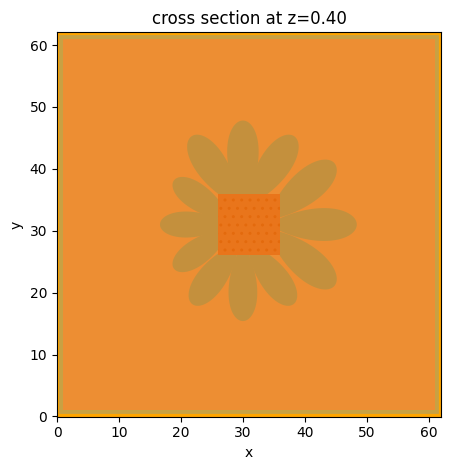

[0.30976516868558995, 0.3392534589139285, 0.7958381243683073, 0.7958381243683073, 0.7958381243683073, 0.7958381243683073, 0.7958381243683073, 0.8765737813789001, 1.0408411322769051, 1.0515238206320414, 1.0858735045403083]


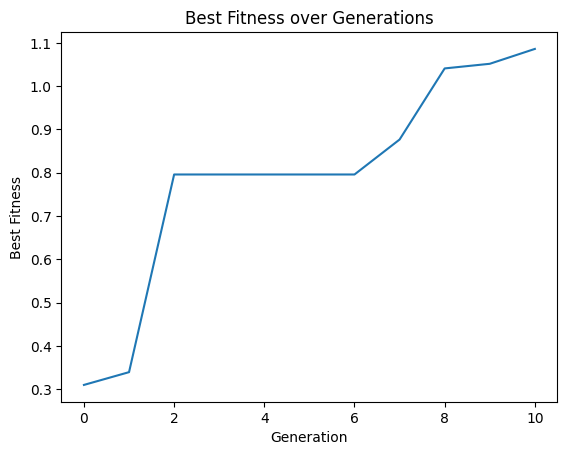

10:36:30 GMT 夏令时 Created task 'best_solution_GA' with task_id                
                    'he-c5a8af68-7268-4b1f-b98d-0770ae5bf0d9' and task_type     
                    'HEAT'.

                 Tidy3D's Heat solver is currently in the beta stage. Cost of   
                 Heat simulations is subject to change in the future.

                 View task using web UI at                                      
                 ]8;id=408108;https://tidy3d.simulation.cloud/workbench?taskId=he-c5a8af68-7268-4b1f-b98d-0770ae5bf0d9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=556582;https://tidy3d.simulation.cloud/workbench?taskId=he-c5a8af68-7268-4b1f-b98d-0770ae5bf0d9\taskId]8;;\]8;id=408108;https://tidy3d.simulation.cloud/workbench?taskId=he-c5a8af68-7268-4b1f-b98d-0770ae5bf0d9\=]8;;\]8;id=549471;https://tidy3d.simulation.cloud/workbench?taskId=he-c5a8af68-7268-4b1f-b98d-0770ae5bf0d9\he]8;;\]8;id=408108;https://tidy3d.simulation.cloud/workbench?taskId=he-c5a8af68-7268-4b1f-b98d-0770ae5bf0d9\-c5a8af68-7]8;;\
                 ]8;id=408108;https://tidy3d.simulation.cloud/workbench?taskId=he-c5a8af68-7268-4b1f-b98d-0770ae5bf0d9\268-4b1f-b98d-0770ae5bf0d9']8;;\.

c:\Users\A\tidy3d\.conda\Lib\site-packages\rich\live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

10:36:33 GMT 夏令时 status = success

10:38:33 GMT 夏令时 loading simulation from sim.hdf5

In [14]:
sim = make_sim_petal(solution)
print(solution)
print(solution_fitness)
sim.plot(z=0.4)
plt.show()
best_fitness = ga_instance.best_solutions_fitness
generations = range(len(best_fitness))
print(best_fitness)
plt.plot(generations, best_fitness)
plt.title("Best Fitness over Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")

plt.show()
heat_sim_data_planar = (web.run(simulation=sim, path = "sim.hdf5", task_name="best_solution_GA"))


<Axes: title={'center': 'cross section at y=30.00'}, xlabel='x', ylabel='z'>

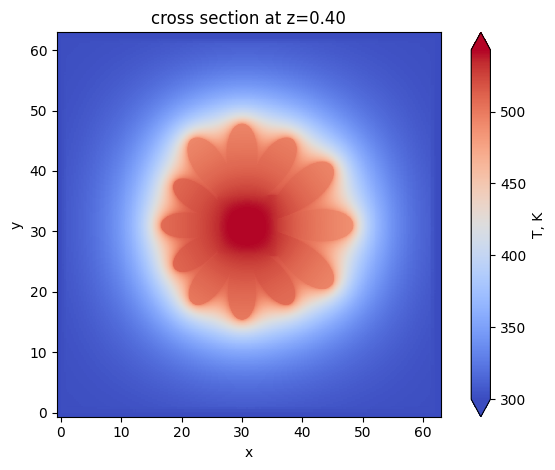

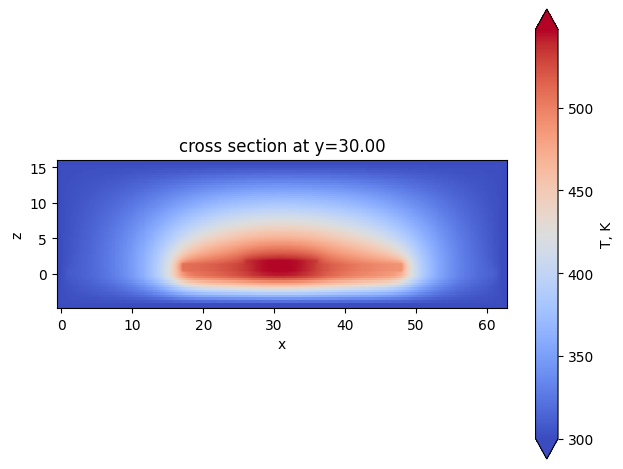

In [17]:
heat_sim_data_planar.plot_field("temperature", z= 0.4, structures_alpha=0.01, vmin=300)
heat_sim_data_planar.plot_field("temperature", y= 30, structures_alpha=0.01, vmin=300)
